In [1]:
from pathlib import Path
import yaml

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.svm import SVC

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy,
)

from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
    DirectMethod as DM,
    DoublyRobust as DR,
    DoublyRobustWithShrinkage as DRos,
    BalancedInverseProbabilityWeighting as BIPW,
    ImportanceSampler,
    PropensityScoreEstimator
)

In [4]:
with open ("../../obp/dataset/hyperparams.yaml", "rb") as f:
    hyperparams = yaml.safe_load(f)

In [5]:
hyperparams

{'lightgbm': {'n_estimators': 100,
  'learning_rate': 0.01,
  'max_depth': 5,
  'min_samples_leaf': 10,
  'random_state': 12345},
 'random_forest': {'n_estimators': 100,
  'max_depth': 5,
  'min_samples_leaf': 10,
  'random_state': 12345},
 'ridge': {'alpha': 0.2, 'random_state': 12345},
 'svc': {'gamma': 2, 'C': 1, 'probability': True, 'random_state': 12345}}

In [6]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [7]:
from tqdm import tqdm_notebook as tqdm

## (1) Generate synthetic data

In [8]:
# define a dataset class
n_actions = 10
dim_context = 8
len_list = 1
random_state = 12345
dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,
    beta=0.2,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=random_state,
)

# training data is used to train an evaluation policy
train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)

# test bandit data is used to approximate the ground-truth policy value
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

## (2) Off-Policy Learning (OPL)

In [9]:
# evaluation policy training
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForestClassifier(**hyperparams["random_forest"]),
)
ipw_learner.fit(
    context=train_bandit_data["context"],
    action=train_bandit_data["action"],
    reward=train_bandit_data["reward"],
    pscore=train_bandit_data["pscore"],
)


action_dist_ipw_train = ipw_learner.predict(
    context=train_bandit_data["context"]
)
action_dist_ipw_test = ipw_learner.predict(
    context=test_bandit_data["context"]
)
policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"],
    action_dist=action_dist_ipw_test,
)

In [10]:
num_data = 3000

validation_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=num_data)

# make decisions on validation data
action_dist_ipw_val = ipw_learner.predict(
    context=validation_bandit_data["context"]
)

## (3) Off-Policy Evaluation (OPE)

### (3-1) Obtaining a reward estimator

In [11]:
# OPE using validation data
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=RandomForestClassifier(**hyperparams["random_forest"]),
)
estimated_rewards = regression_model.fit_predict(
    context=validation_bandit_data["context"],  # context; x
    action=validation_bandit_data["action"],  # action; a
    reward=validation_bandit_data["reward"],  # reward; r
    n_folds=2,  # 2-fold cross fitting
    random_state=12345,
)

### (3-2) Evaluation by existing OPE estimators

In [12]:
classification_model_action = PropensityScoreEstimator(
    len_list=len_list,
    n_actions=n_actions,
    base_model=RandomForestClassifier(**hyperparams["random_forest"]),
    calibration_cv=2
    # base_model=SVC(gamma=2, C=1, probability=True),
    # base_model=MLPClassifier(alpha=1, max_iter=1000),
)

estimated_pscore = classification_model_action.fit_predict(
    action=validation_bandit_data["action"],
    position=validation_bandit_data["position"],
    context=validation_bandit_data["context"],
    n_folds=2,
    is_eval_model=True,
    random_state=random_state,
)


In [13]:
ope = OffPolicyEvaluation(
    bandit_feedback=validation_bandit_data,
    ope_estimators=[
        IPS(estimator_name="IPS"),
        DM(estimator_name="DM"),
        IPS(lambda_=100, estimator_name="CIPS"),
        SNIPS(estimator_name="SNIPS"),
        DR(estimator_name="DR"),
        DRos(lambda_=500, estimator_name="DRos"),
        IPS(
            lambda_=100,
            estimator_name="CIPS_Estimated_Pscore",
            use_estimated_pscore=True,
        ),
        SNIPS(estimator_name="SNIPS_Estimated_Pscore", use_estimated_pscore=True),
        DR(estimator_name="DR_Estimated_Pscore", use_estimated_pscore=True),
        DRos(
            lambda_=500,
            estimator_name="DRos_Estimated_Pscore",
            use_estimated_pscore=True,
        ),
    ],
)


squared_errors = ope.evaluate_performance_of_estimators(
    ground_truth_policy_value=policy_value_of_ipw,  # V(\pi_e)
    action_dist=action_dist_ipw_val,  # \pi_e(a|x)
    estimated_rewards_by_reg_model=estimated_rewards,  # \hat{q}(x,a)
    estimated_pscore=estimated_pscore,
    metric="se",  # squared error
)

ope_result = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_val,  # \pi_e(a|x)
    estimated_rewards_by_reg_model=estimated_rewards,  # \hat{q}(x,a)
    estimated_pscore=estimated_pscore,
)

In [14]:
ope_result[0]

,estimated_policy_value,relative_estimated_policy_value
IPS,0.700004,1.418927
DM,0.522973,1.060081
CIPS,0.700004,1.418927
SNIPS,0.697155,1.413152
DR,0.703660,1.426337
DRos,0.674096,1.366411
CIPS_Estimated_Pscore,0.730438,1.480617
SNIPS_Estimated_Pscore,0.697635,1.414126
DR_Estimated_Pscore,0.711952,1.443147
DRos_Estimated_Pscore,0.678466,1.375268


In [15]:
ope_result[1]

,mean,95.0% CI (lower),95.0% CI (upper)
IPS,0.699814,0.616869,0.788597
DM,0.523240,0.520367,0.525819
CIPS,0.702714,0.622015,0.779564
SNIPS,0.702828,0.616837,0.798372
DR,0.705942,0.646994,0.761316
DRos,0.674738,0.620903,0.721863
CIPS_Estimated_Pscore,0.719954,0.627332,0.802852
SNIPS_Estimated_Pscore,0.697381,0.602212,0.778892
DR_Estimated_Pscore,0.706322,0.644805,0.777228
DRos_Estimated_Pscore,0.678837,0.642032,0.714253


In [16]:
# true policy value
policy_value_of_ipw

0.6998367440243847

### (3-3) Balanced-OPE

In [17]:
bipw = BIPW(
    estimator_name="BIPW", lambda_=np.inf
)

In [18]:
clf_models = {
    "random_forest_default_raw": ImportanceSampler(
        len_list=len_list,
        n_actions=n_actions,
        fitting_method="raw",
        base_model=RandomForestClassifier(random_state=random_state),
    ),
    "random_forest_raw": ImportanceSampler(
        len_list=len_list,
        n_actions=n_actions,
        fitting_method="raw",
        base_model=RandomForestClassifier(**hyperparams["random_forest"]),
    ),
    "random_forest_sample": ImportanceSampler(
        len_list=len_list,
        n_actions=n_actions,
        fitting_method="sample",
        base_model=RandomForestClassifier(**hyperparams["random_forest"]),
    ),
    "svc_raw": ImportanceSampler(
        len_list=len_list,
        n_actions=n_actions,
        fitting_method="raw",
        base_model=SVC(**hyperparams["svc"]),
    ),
    "svc_sample": ImportanceSampler(
        len_list=len_list,
        n_actions=n_actions,
        fitting_method="sample",
        base_model=SVC(**hyperparams["svc"]),
    ),
    "MLP_raw": ImportanceSampler(
        len_list=len_list,
        n_actions=n_actions,
        fitting_method="raw",
        base_model=MLP(random_state=random_state),
    ),
    "MLP_sample": ImportanceSampler(
        len_list=len_list,
        n_actions=n_actions,
        fitting_method="sample",
        base_model=MLP(random_state=random_state),
    ),
}

In [19]:
balancing_weight_dict = {}
for clf_name, clf in tqdm(clf_models.items()):
    balancing_weight_dict[clf_name] = clf.fit_predict(
        action=validation_bandit_data["action"],
        context=validation_bandit_data["context"],
        action_dist=action_dist_ipw_val,
        position=validation_bandit_data["position"],
        n_folds=2,
        is_eval_model=True,
        random_state=random_state,
    )

<ipython-input-19-a5b3906b74b0>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for clf_name, clf in tqdm(clf_models.items()):


  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
policy_values = {}
for clf_name in clf_models:
    policy_values[clf_name] = bipw.estimate_policy_value(
        reward=validation_bandit_data["reward"],
        action=validation_bandit_data["action"],
        position=validation_bandit_data["position"],
        action_dist=action_dist_ipw_val,
        context=validation_bandit_data["context"],
        importance_sampling_ratio=balancing_weight_dict[clf_name],
    )

In [21]:
policy_values

{'random_forest_default_raw': 0.7181800744277534,
 'random_forest_raw': 0.7371142420861926,
 'random_forest_sample': 0.7371142420861926,
 'svc_raw': 0.6774325665018398,
 'svc_sample': 0.6774325665018398,
 'MLP_raw': 0.705304897735028,
 'MLP_sample': 0.705304897735028}

## (4) Evaluation of OPE

### (4-1) OPE performance visualization

In [22]:
ope_expected_values = ope_result[0]["estimated_policy_value"].append(pd.Series(policy_values))

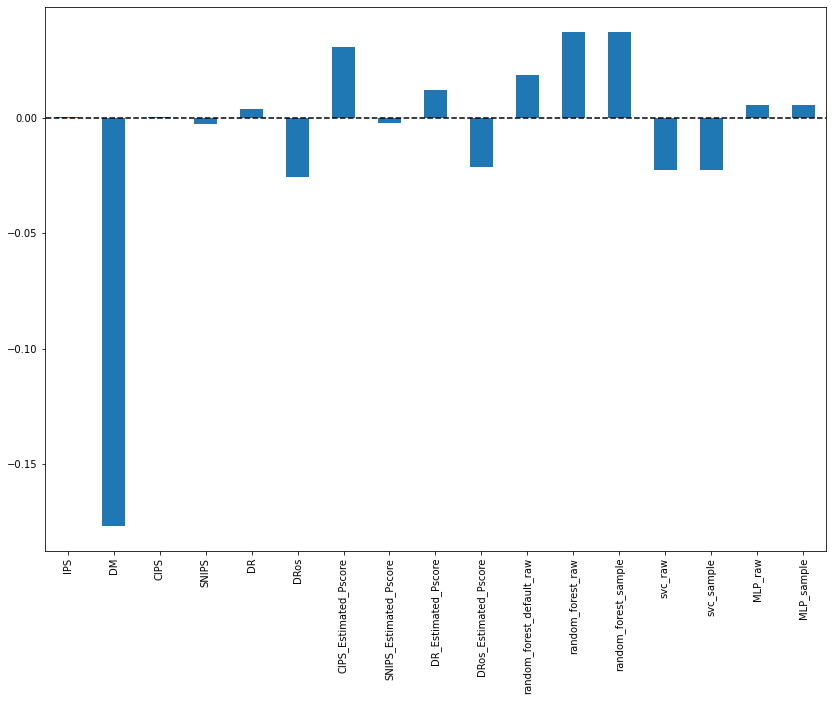

In [23]:
fig = plt.figure(figsize=(14, 10))
(ope_expected_values - policy_value_of_ipw).plot.bar()
plt.hlines(y=0., xmin=-1, xmax=len(ope_expected_values), color="black", linestyles="--")

### (4-2) Summarize

In [24]:
ope_add_bipw = OffPolicyEvaluation(
    bandit_feedback=validation_bandit_data,
    ope_estimators=[
        IPS(estimator_name="IPS"),
        DM(estimator_name="DM"),
        IPS(lambda_=100, estimator_name="CIPS"),
        SNIPS(estimator_name="SNIPS"),
        DR(estimator_name="DR"),
        DRos(lambda_=500, estimator_name="DRos"),
        IPS(
            lambda_=100,
            estimator_name="CIPS_Estimated_Pscore",
            use_estimated_pscore=True,
        ),
        SNIPS(estimator_name="SNIPS_Estimated_Pscore", use_estimated_pscore=True),
        DR(estimator_name="DR_Estimated_Pscore", use_estimated_pscore=True),
        DRos(
            lambda_=500,
            estimator_name="DRos_Estimated_Pscore",
            use_estimated_pscore=True,
        ),
        BIPW(estimator_name="BIPW_rf_raw", lambda_=np.inf),
        BIPW(estimator_name="BIPW_rf_sample", lambda_=np.inf),
        BIPW(estimator_name="BIPW_rf_sample_clip", lambda_=10.0),
    ],
)


In [26]:
isr = {
    "BIPW_rf_raw": balancing_weight_dict["random_forest_raw"],
    "BIPW_rf_sample": balancing_weight_dict["random_forest_sample"],
    "BIPW_rf_sample_clip": balancing_weight_dict["random_forest_sample"],
}

squared_errors = ope_add_bipw.evaluate_performance_of_estimators(
    ground_truth_policy_value=policy_value_of_ipw,  # V(\pi_e)
    action_dist=action_dist_ipw_val,  # \pi_e(a|x)
    estimated_rewards_by_reg_model=estimated_rewards,  # \hat{q}(x,a)
    estimated_pscore=estimated_pscore,
    importance_sampling_ratio=isr,
    metric="se",  # squared error
)

ope_add_bipw_res = ope_add_bipw.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_val,  # \pi_e(a|x)
    estimated_rewards_by_reg_model=estimated_rewards,  # \hat{q}(x,a)
    estimated_pscore=estimated_pscore,
    importance_sampling_ratio=isr,
)

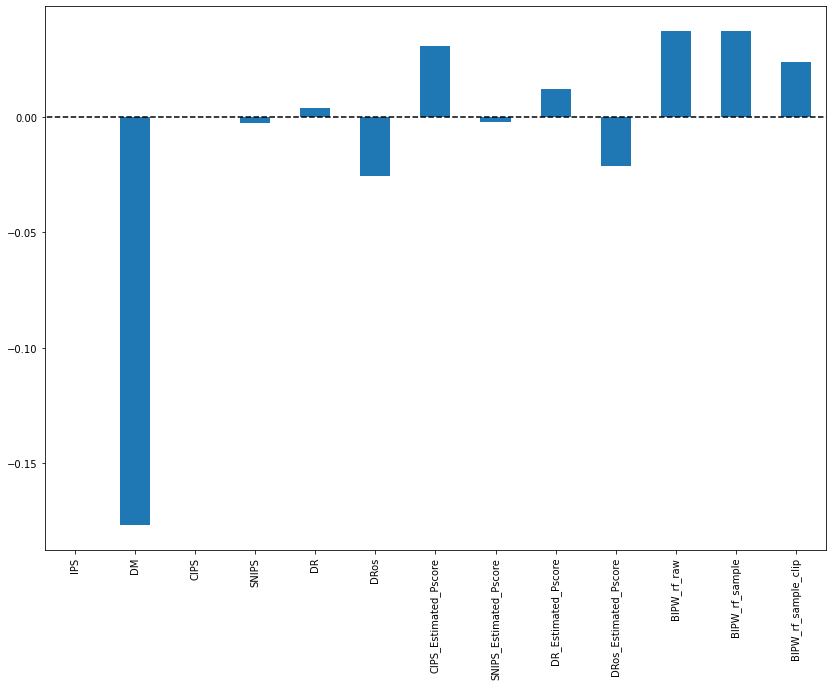

In [30]:
fig = plt.figure(figsize=(14, 10))
(ope_add_bipw_res[0]["estimated_policy_value"] - policy_value_of_ipw).plot.bar()
plt.hlines(y=0., xmin=-1, xmax=len(ope_add_bipw_res[0]["estimated_policy_value"]), color="black", linestyles="--")

### (4-3) Classification model visualization

In [31]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve

In [32]:
def plot_calibration_curve(y_test, y_pred, name):
    """Plot calibration curve for est w/o and with calibration. """
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, y_pred, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-")

    ax2.hist(y_pred, range=(0, 1), bins=10,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title(f'Calibration plots  (reliability curve): {name}')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

    plt.tight_layout()

In [33]:
def plot_roc_auc_curve(y_test, y_pred, name):
    fig = plt.figure(figsize=(10, 5))
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="data 1, auc=%1.3f" %auc)
    plt.legend(loc=4)
    plt.title(f"ROC AUC curve: {name}")
    plt.tight_layout()

random_forest_default_raw
random_forest_raw
random_forest_sample
svc_raw
svc_sample
MLP_raw
MLP_sample


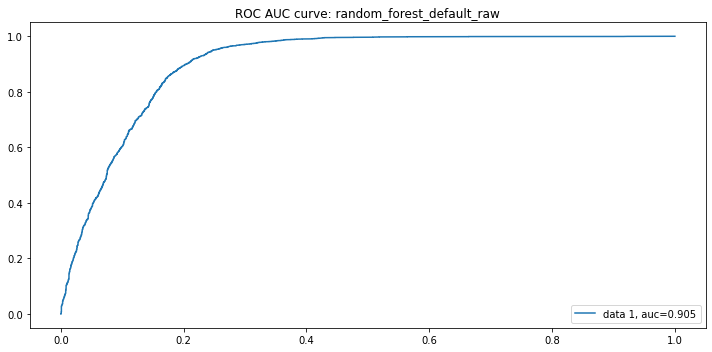

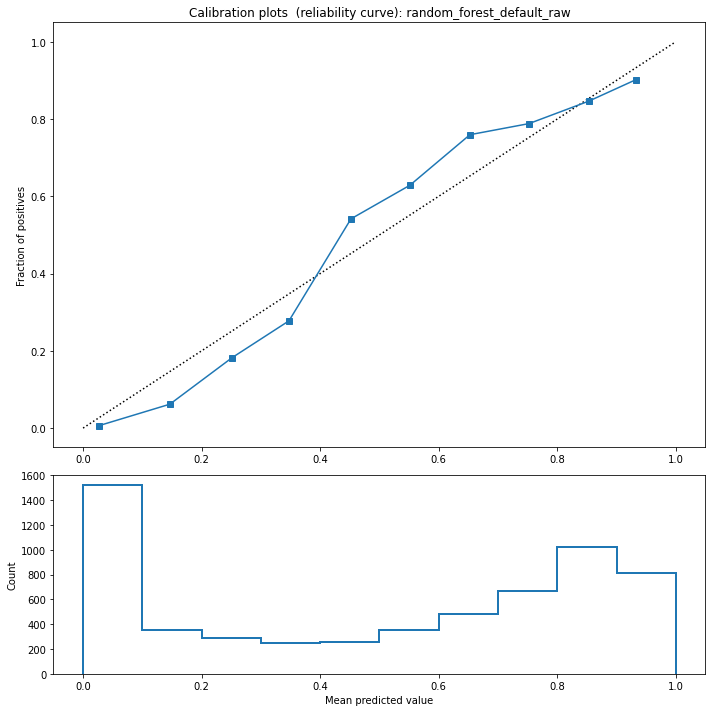

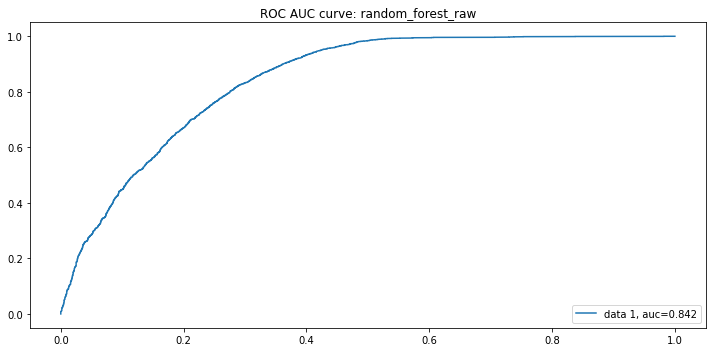

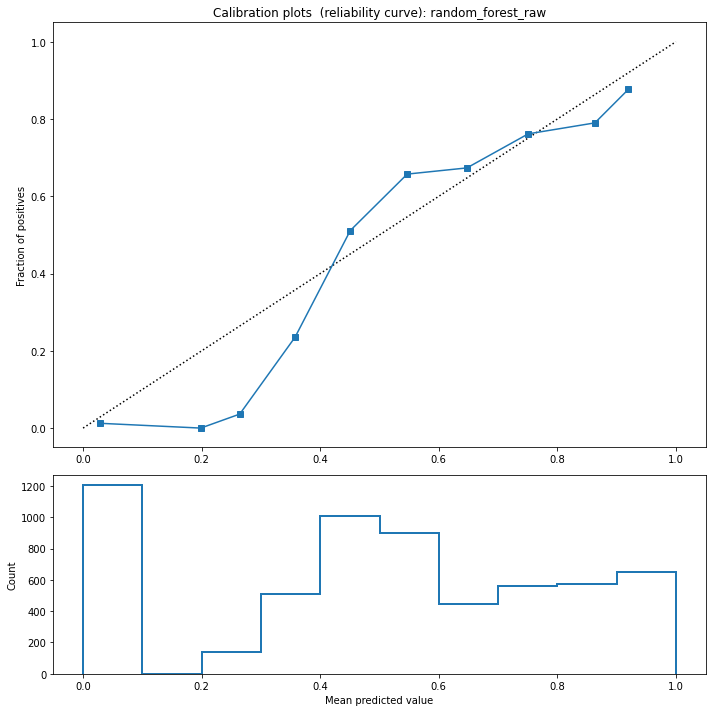

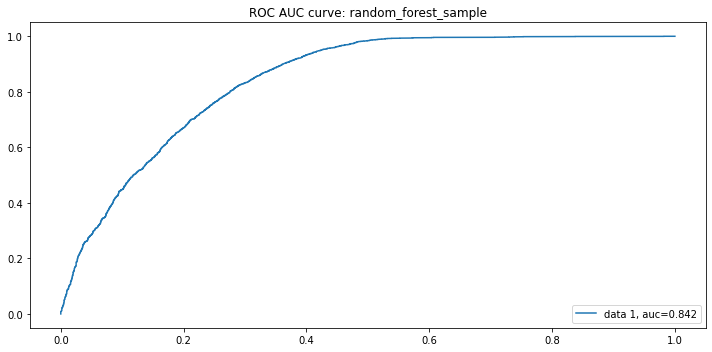

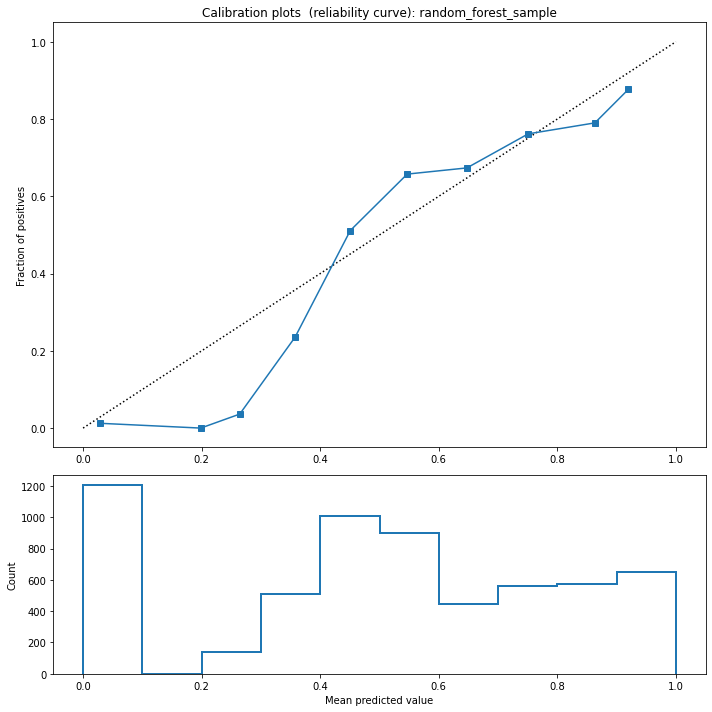

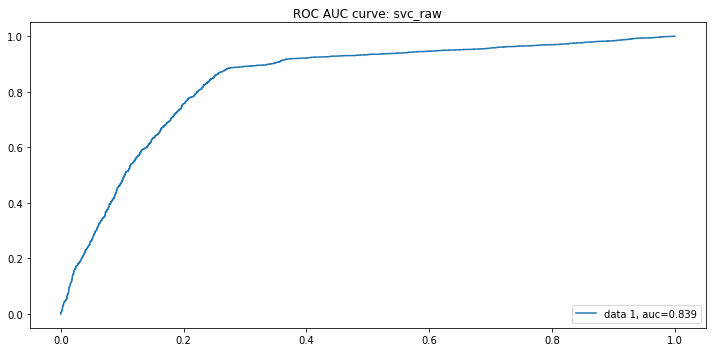

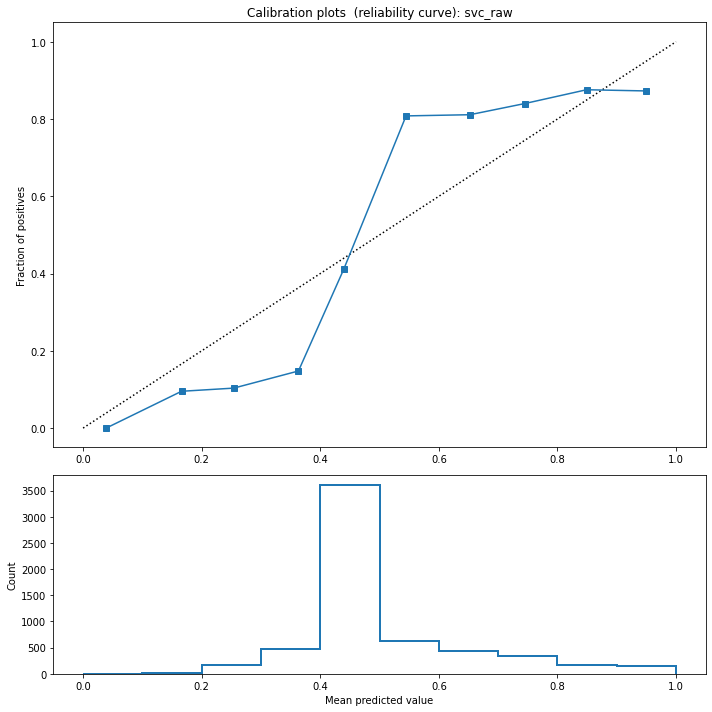

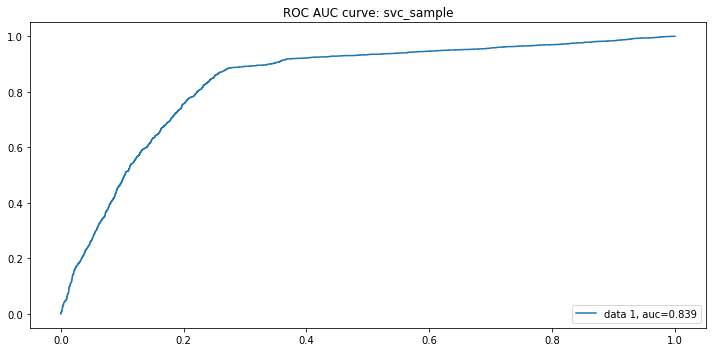

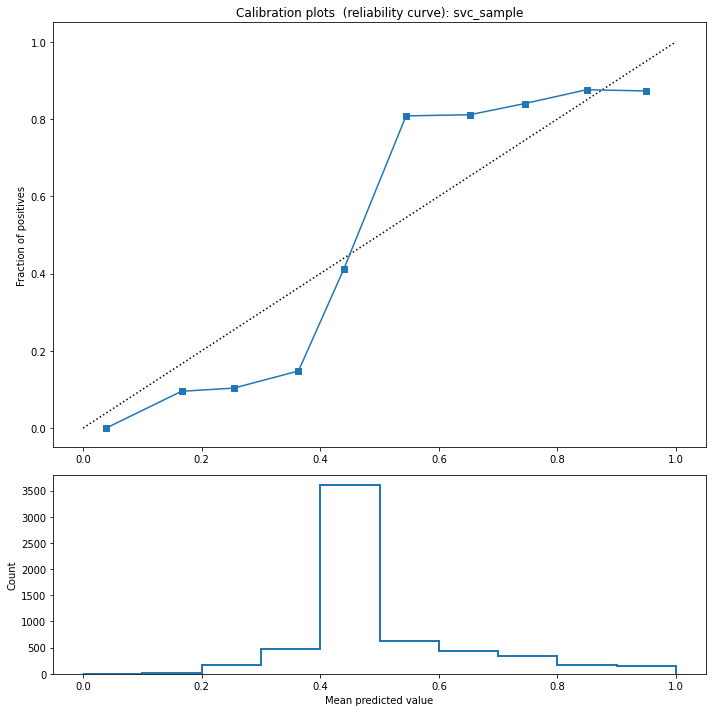

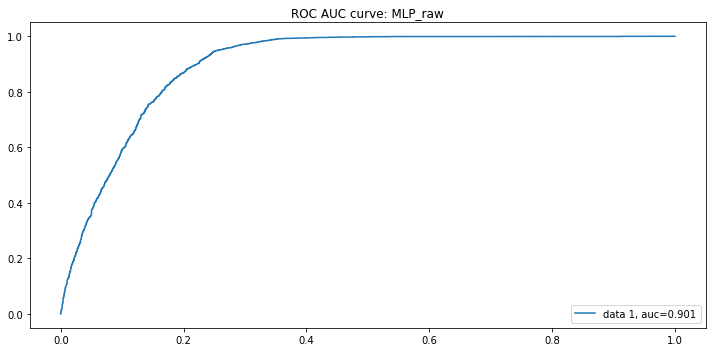

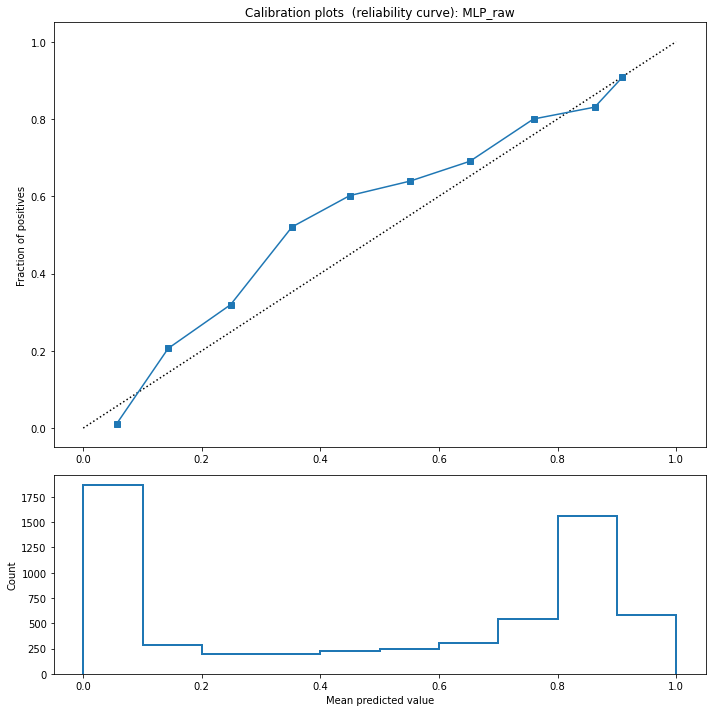

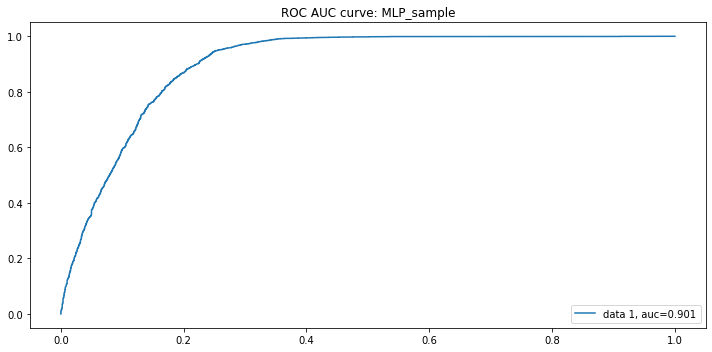

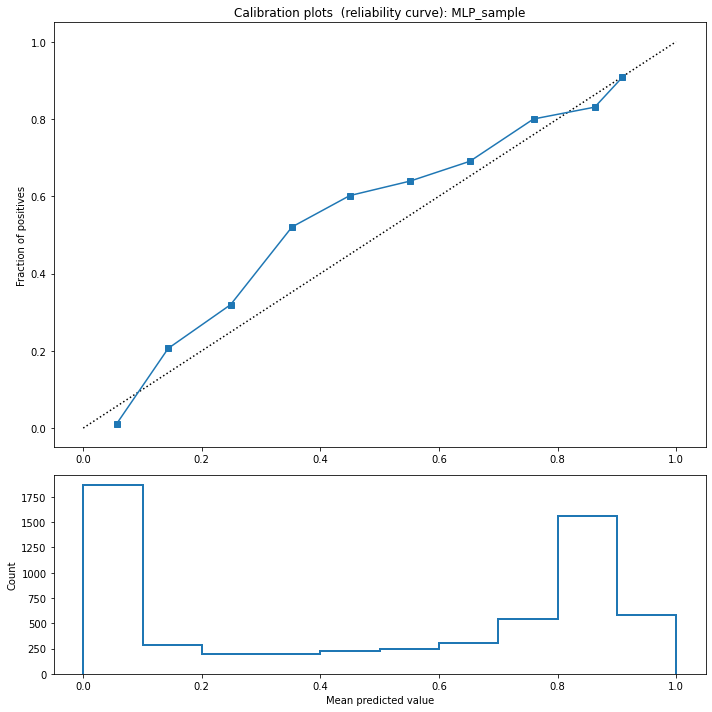

In [34]:
n_cv = 2
for clf_name, clf in clf_models.items():
    if "weighted_loss" in clf_name:
        continue
    tmp_y = []
    tmp_pred = []
    for cv in range(n_cv):
        tmp_y.append(clf.eval_result["y"][cv])
        tmp_pred.append(clf.eval_result["proba"][cv])
    print(clf_name)
    y_test = np.array(tmp_y).flatten()
    y_pred = np.array(tmp_pred).flatten()
    plot_roc_auc_curve(y_test, y_pred, clf_name)
    plot_calibration_curve(y_test, y_pred, clf_name)